In [1]:
from awpy import Demo

import torch

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import load, dump
import random
import json
import sys
import os

pd.set_option('display.max_columns', 100)
sys.path.append(os.path.abspath('./package'))

from CS2.graph import TabularGraphSnapshot, HeteroGraphSnapshot
from CS2.token import Tokenizer
from CS2.preprocess import Dictionary, NormalizePosition, NormalizeTabularGraphSnapshot, ImputeTabularGraphSnapshot
from CS2.visualize import HeteroGraphVisualizer

### ***awpy2*** test

In [5]:
dem = Demo(path='../../data/matches-raw/cs2/2024/_blast-premier-spring-final-2024-faze-vs-vitality-bo3-lQLvdLlJcL7dI4fNDLSZOXfaze-vs-vitality-m1-inferno.dem', player_props=['mvps'])

In [3]:
dem = Demo(path='../../data/matches-raw/cs2/2024/_blast-premier-spring-groups-2024-g2-vs-natus-vincere-bo3-YNZzdluz2vLlZbsmgT1lX3g2-vs-natus-vincere-m2-inferno.dem')

### **Graph Creator** Test

In [4]:
# PROCESS FLAG - whether the match has been normalized or not
MATCH_NORMALIZED = False

# Map nodes dataset
nodes = pd.read_csv('../../data/map_graph_model/de_inferno/nodes.csv')
edges = pd.read_csv('../../data/map_graph_model/de_inferno/edges.csv')

# Create tabular snapshot object
tg = TabularGraphSnapshot()

# Create tabular snapshot database
df, df_dict, active_infernos, active_smokes, active_he_smokes = tg.process_match(
    match_path='../../data/matches-raw/cs2/2024/_iem-chengdu-2024-wildcard-vs-virtuspro-inferno-norx8DdKJD9R1hFM8pob5fwildcard-vs-virtus-pro-inferno.dem',
    player_stats_data_path='../../data/player-stats/scraped-in-2024/2022/norm_imputed_player_stats_2022_utf.csv',
    missing_player_stats_data_path='../../data/player-stats/missing_players_df.csv',
    weapon_data_path='../../data/weapon_info/ammo_info.csv',

    ticks_per_second=4,
    numerical_match_id=1000,
    num_permutations_per_round=1,
    build_dictionary=True
)

# Impute missing values
its = ImputeTabularGraphSnapshot()
df = its.impute(df)

# Tokenize match
tokenizer = Tokenizer()
df = tokenizer.tokenize_match(df, 'de_inferno', nodes)

df.head(5)

,CT0_name,CT0_X,CT0_Y,CT0_Z,CT0_pitch,CT0_yaw,CT0_velocity_X,CT0_velocity_Y,CT0_velocity_Z,CT0_health,CT0_armor_value,CT0_active_weapon_magazine_size,CT0_active_weapon_ammo,CT0_active_weapon_magazine_ammo_left_%,CT0_active_weapon_max_ammo,CT0_total_ammo_left,CT0_active_weapon_total_ammo_left_%,CT0_flash_duration,CT0_flash_max_alpha,CT0_balance,CT0_current_equip_value,CT0_round_start_equip_value,CT0_cash_spent_this_round,CT0_is_alive,CT0_is_CT,CT0_is_shooting,CT0_is_crouching,CT0_is_ducking,CT0_is_duck_jumping,CT0_is_walking,CT0_is_spotted,CT0_is_scoped,CT0_is_defusing,CT0_is_reloading,CT0_is_in_bombsite,CT0_zoom_lvl,CT0_velo_modifier,CT0_stat_kills,CT0_stat_HS_kills,CT0_stat_opening_kills,CT0_stat_MVPs,CT0_stat_deaths,CT0_stat_opening_deaths,CT0_stat_assists,CT0_stat_flash_assists,CT0_stat_damage,CT0_stat_weapon_damage,CT0_stat_nade_damage,CT0_stat_survives,CT0_stat_KPR,...,T9_hltv_opening_kill_rating,T9_hltv_team_W%_after_opening,T9_hltv_opening_kill_in_W_rounds,T9_hltv_rating_1.0_all_Career,T9_hltv_clutches_1on1_ratio,T9_hltv_clutches_won_1on1,T9_hltv_clutches_won_1on2,T9_hltv_clutches_won_1on3,T9_hltv_clutches_won_1on4,T9_hltv_clutches_won_1on5,NUMERICAL_MATCH_ID,MATCH_ID,UNIVERSAL_tick,UNIVERSAL_round,UNIVERSAL_time,UNIVERSAL_remaining_time,UNIVERSAL_freeze_end,UNIVERSAL_end,UNIVERSAL_CT_wins,UNIVERSAL_CT_score,UNIVERSAL_T_score,UNIVERSAL_CT_alive_num,UNIVERSAL_T_alive_num,UNIVERSAL_CT_total_hp,UNIVERSAL_T_total_hp,UNIVERSAL_CT_equipment_value,UNIVERSAL_T_equipment_value,UNIVERSAL_CT_losing_streak,UNIVERSAL_T_losing_streak,UNIVERSAL_is_bomb_dropped,UNIVERSAL_is_bomb_being_planted,UNIVERSAL_is_bomb_being_defused,UNIVERSAL_is_bomb_defused,UNIVERSAL_is_bomb_planted_at_A_site,UNIVERSAL_is_bomb_planted_at_B_site,UNIVERSAL_bomb_X,UNIVERSAL_bomb_Y,UNIVERSAL_bomb_Z,UNIVERSAL_bomb_mx_pos1,UNIVERSAL_bomb_mx_pos2,UNIVERSAL_bomb_mx_pos3,UNIVERSAL_bomb_mx_pos4,UNIVERSAL_bomb_mx_pos5,UNIVERSAL_bomb_mx_pos6,UNIVERSAL_bomb_mx_pos7,UNIVERSAL_bomb_mx_pos8,UNIVERSAL_bomb_mx_pos9,UNIVERSAL_CT_clan_name,UNIVERSAL_T_clan_name,TOKEN
0,fame,2353.000000,1977.000000,135.518890,6.993835,-95.568008,0.000000,0.000000,0.000000,100,100,0,0.0,0.0,0,1.0,0.0,0.0,255.0,150,850,200,650,True,1,False,0,0,0,False,False,False,False,False,False,0.0,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1,0.0,...,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1263,1,115.00,115.00,1263,6403,1,0,0,5,5,500,500,4600,5000,1,1,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,Virtus.Pro,Wildcard Gaming,1000000000050000000000000000000000000000000000...
1,fame,2350.104736,1947.279297,135.539261,6.993835,-95.568008,-0.281738,-2.892334,0.001312,100,100,0,0.0,0.0,0,1.0,0.0,0.0,255.0,150,850,200,650,True,1,False,0,0,0,False,False,False,False,False,False,0.0,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1,0.0,...,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1279,1,114.75,114.75,1263,6403,1,0,0,5,5,500,500,4600,5000,1,1,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,Virtus.Pro,Wildcard Gaming,1000000000050000000000000000000000000000000000...
2,fame,2344.702148,1890.890381,136.600327,6.630936,-94.624214,-0.351807,-3.798950,0.002365,100,100,0,0.0,0.0,0,1.0,0.0,0.0,255.0,150,850,200,650,True,1,True,0,0,0,False,False,False,False,False,False,0.0,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1,0.0,...,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1295,1,114.50,114.50,1263,6403,1,0,0,5,5,500,500,4600,5000,1,1,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,Virtus.Pro,Wildcard Gaming,1000000000050000000000000000000000000000000000...
3,fame,2340.188232,1828.620605,139.374146,5.033447,-90.921822,-0.212891,-3.900391,0.021667,100,100,0,0.0,0.0,0,1.0,0.0,0.0,255.0,150,850,200,650,True,1,False,0,0,0,False,False,False,False,False,False,0.0,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1,0.0,...,0.54321,0.857,0.444444,0.571429,1

In [5]:
# Build dictionary
dictionary = Dictionary().build_single_dictionary(df_dict)

# Get map normalization config file
inferno_norm_config = '../../config/game/map_normalization/inferno.json'
with open(inferno_norm_config, 'r') as f:
    CONFIG_INF_NORM = json.load(f)

# Normalize active nade dataframes
np = NormalizePosition()
active_infernos = np.normalize(active_infernos, CONFIG_INF_NORM)
active_smokes = np.normalize(active_smokes, CONFIG_INF_NORM)
active_he_smokes = np.normalize(active_he_smokes, CONFIG_INF_NORM)

# Normalize match
nts = NormalizeTabularGraphSnapshot()
df = nts.noramlize(df, dictionary, CONFIG_INF_NORM)

# Set the process flag to True
MATCH_NORMALIZED = True

df.head(5)

,CT0_name,CT0_X,CT0_Y,CT0_Z,CT0_pitch,CT0_yaw,CT0_velocity_X,CT0_velocity_Y,CT0_velocity_Z,CT0_health,CT0_armor_value,CT0_active_weapon_magazine_size,CT0_active_weapon_ammo,CT0_active_weapon_magazine_ammo_left_%,CT0_active_weapon_max_ammo,CT0_total_ammo_left,CT0_active_weapon_total_ammo_left_%,CT0_flash_duration,CT0_flash_max_alpha,CT0_balance,CT0_current_equip_value,CT0_round_start_equip_value,CT0_cash_spent_this_round,CT0_is_alive,CT0_is_CT,CT0_is_shooting,CT0_is_crouching,CT0_is_ducking,CT0_is_duck_jumping,CT0_is_walking,CT0_is_spotted,CT0_is_scoped,CT0_is_defusing,CT0_is_reloading,CT0_is_in_bombsite,CT0_zoom_lvl,CT0_velo_modifier,CT0_stat_kills,CT0_stat_HS_kills,CT0_stat_opening_kills,CT0_stat_MVPs,CT0_stat_deaths,CT0_stat_opening_deaths,CT0_stat_assists,CT0_stat_flash_assists,CT0_stat_damage,CT0_stat_weapon_damage,CT0_stat_nade_damage,CT0_stat_survives,CT0_stat_KPR,...,T9_hltv_opening_kill_rating,T9_hltv_team_W%_after_opening,T9_hltv_opening_kill_in_W_rounds,T9_hltv_rating_1.0_all_Career,T9_hltv_clutches_1on1_ratio,T9_hltv_clutches_won_1on1,T9_hltv_clutches_won_1on2,T9_hltv_clutches_won_1on3,T9_hltv_clutches_won_1on4,T9_hltv_clutches_won_1on5,NUMERICAL_MATCH_ID,MATCH_ID,UNIVERSAL_tick,UNIVERSAL_round,UNIVERSAL_time,UNIVERSAL_remaining_time,UNIVERSAL_freeze_end,UNIVERSAL_end,UNIVERSAL_CT_wins,UNIVERSAL_CT_score,UNIVERSAL_T_score,UNIVERSAL_CT_alive_num,UNIVERSAL_T_alive_num,UNIVERSAL_CT_total_hp,UNIVERSAL_T_total_hp,UNIVERSAL_CT_equipment_value,UNIVERSAL_T_equipment_value,UNIVERSAL_CT_losing_streak,UNIVERSAL_T_losing_streak,UNIVERSAL_is_bomb_dropped,UNIVERSAL_is_bomb_being_planted,UNIVERSAL_is_bomb_being_defused,UNIVERSAL_is_bomb_defused,UNIVERSAL_is_bomb_planted_at_A_site,UNIVERSAL_is_bomb_planted_at_B_site,UNIVERSAL_bomb_X,UNIVERSAL_bomb_Y,UNIVERSAL_bomb_Z,UNIVERSAL_bomb_mx_pos1,UNIVERSAL_bomb_mx_pos2,UNIVERSAL_bomb_mx_pos3,UNIVERSAL_bomb_mx_pos4,UNIVERSAL_bomb_mx_pos5,UNIVERSAL_bomb_mx_pos6,UNIVERSAL_bomb_mx_pos7,UNIVERSAL_bomb_mx_pos8,UNIVERSAL_bomb_mx_pos9,UNIVERSAL_CT_clan_name,UNIVERSAL_T_clan_name,TOKEN
0,fame,0.963250,0.619250,0.033880,0.479426,0.234506,0.519795,0.505849,0.554759,1.0,1.0,0.0,0.0,0.0,0.0,0.008333,0.0,0.0,1.0,0.009375,0.082803,0.0,0.07027,True,1,False,0,0,0,False,False,False,False,False,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,...,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1263,0.041667,1.000000,1.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.144427,0.189394,0.2,0.2,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,Virtus.Pro,Wildcard Gaming,1000000000050000000000000000000000000000000000...
1,fame,0.962526,0.611820,0.033885,0.479426,0.234506,0.487757,0.170550,0.554796,1.0,1.0,0.0,0.0,0.0,0.0,0.008333,0.0,0.0,1.0,0.009375,0.082803,0.0,0.07027,True,1,False,0,0,0,False,False,False,False,False,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,...,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1279,0.041667,0.998155,0.997913,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.144427,0.189394,0.2,0.2,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,Virtus.Pro,Wildcard Gaming,1000000000050000000000000000000000000000000000...
2,fame,0.961176,0.597723,0.034150,0.477123,0.237128,0.479789,0.065449,0.554827,1.0,1.0,0.0,0.0,0.0,0.0,0.008333,0.0,0.0,1.0,0.009375,0.082803,0.0,0.07027,True,1,True,0,0,0,False,False,False,False,False,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,...,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1295,0.041667,0.996310,0.995826,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.144427,0.189394,0.2,0.2,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,Virtus.Pro,Wildcard Gaming,1000000000050000000000000000000000000000000000...
3,fame,0.960047,0.582155,0.034844,0.466982,0.247413,0.495586,0.053690,0.555382,1.0,1.0,0

In [6]:
# Prepare the nodes dataframes
if MATCH_NORMALIZED:
    nodes_to_use = pd.read_csv('../../data/map_graph_model/de_inferno/nodes_norm.csv')
else:
    nodes_to_use = pd.read_csv('../../data/map_graph_model/de_inferno/nodes.csv')


# Set the config file for the molotov and smoke radius
if MATCH_NORMALIZED:
    molotov_radius_config = '../../config/game/nade_radius/molotov_norm.json'
    smoke_radius_config = '../../config/game/nade_radius/smoke_norm.json'
else:
    molotov_radius_config = '../../config/game/nade_radius/molotov.json'
    smoke_radius_config = '../../config/game/nade_radius/smoke.json'

# Read the molotov and smoke radius config data
with open(molotov_radius_config, 'r') as f:
    CONFIG_MOLOTOV_RADIUS = json.load(f)
with open(smoke_radius_config, 'r') as f:
    CONFIG_SMOKE_RADIUS = json.load(f)


# Graph snapshots
hg = HeteroGraphSnapshot()
graphs = hg.process_snapshots(df, nodes_to_use, edges, active_infernos, active_smokes, active_he_smokes, CONFIG_MOLOTOV_RADIUS, CONFIG_SMOKE_RADIUS)

In [7]:
torch.save(graphs, 'TEST_hetero_data_list.pt')

### **Graph Visualizer** Test

In [2]:
graphs = torch.load('TEST_hetero_data_list.pt', weights_only=False)

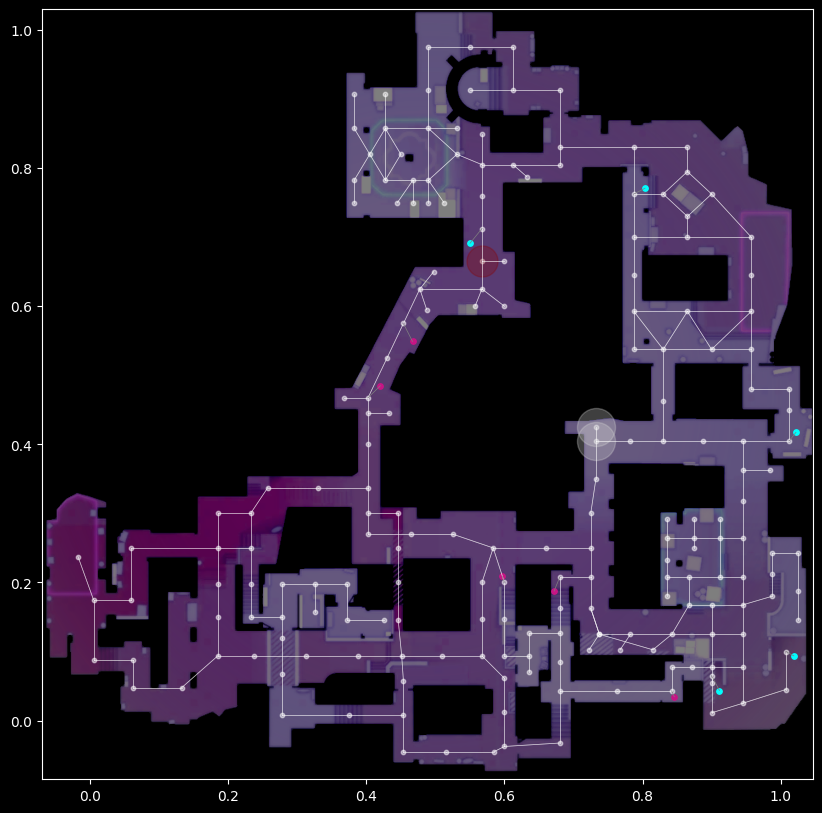

In [4]:
viz = HeteroGraphVisualizer()
viz.visualize_snapshot(graphs[1540], 'dark', '../../_/CS2_inferno_radar_dark_2.png')